In [1]:
import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import os

In [4]:
import librosa 
import numpy as np 

from tqdm import tqdm

In [5]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical 
from sklearn.preprocessing import LabelEncoder 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout,Activation,Flatten 
from tensorflow.keras.optimizers import Adam

In [6]:
from sklearn import metrics 
from tensorflow.keras.callbacks import ModelCheckpoint 
from datetime import datetime

In [7]:
import librosa 
audio_file_path="UrbanSound8K/8.wav" 
librosa_audio_data, librosa_sample_rate=librosa.load(audio_file_path)

In [8]:
from IPython.display import Audio 
Audio('UrbanSound8K/11.wav')

In [9]:
mfccs = librosa.feature.mfcc(y=librosa_audio_data,sr=librosa_sample_rate, n_mfcc=40)

In [10]:
mfccs.shape

(40, 173)

In [11]:
mfccs

array([[-3.08277618e+02, -2.69249146e+02, -2.55008453e+02, ...,
        -1.16894707e+02, -1.15878265e+02, -1.25340546e+02],
       [ 9.37794113e+00,  4.30035543e+00,  1.79951210e+01, ...,
         8.11297512e+00,  6.43620968e+00,  1.08383827e+01],
       [-2.35883484e+01, -2.34981213e+01, -2.14797554e+01, ...,
        -4.30597839e+01, -4.30493813e+01, -3.87034950e+01],
       ...,
       [ 6.56631088e+00,  6.85382271e+00,  2.51694822e+00, ...,
         2.29168725e+00,  3.92383909e+00,  9.22230911e+00],
       [-9.94714355e+00, -7.84821749e+00, -6.36572504e+00, ...,
        -2.04297614e+00, -1.32223570e+00,  5.17253780e+00],
       [-4.87069893e+00, -1.34847593e+00,  1.90117002e-01, ...,
         3.91125631e+00,  5.15037966e+00,  5.37938452e+00]], dtype=float32)

In [12]:
audio_dataset_path="UrbanSound8K/audio/" 
metadata=pd.read_csv("UrbanSound8k/metadata/UrbanSound8K.csv") 
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [13]:
def feature_extractor(file):
    audio, sample_rate = librosa.load(file_name,res_type="kaiser_fast") 
    mfccs_features=librosa.feature.mfcc(y=audio,sr=sample_rate,n_mfcc=40) 
    mfccs_scaled_features=np.mean(mfccs_features.T,axis=0) 

    return mfccs_scaled_features

In [14]:
extracted_features=[] 
for index_num,row in tqdm(metadata.iterrows()):
    file_name=os.path.join(os.path.abspath(audio_dataset_path), "fold"+str(row["fold"])+"/",str(row["slice_file_name"]))
    final_class_labels=row["class"] 
    data=feature_extractor(file_name) 
    extracted_features.append([data,final_class_labels])

3554it [02:31, 23.33it/s]c:\Users\MonsterOne\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
8324it [05:35, 32.87it/s]c:\Users\MonsterOne\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
c:\Users\MonsterOne\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
8732it [05:50, 24.91it/s]


In [15]:
extracted_features_df=pd.DataFrame(extracted_features,columns=["features","class"]) 
extracted_features_df.head()

,features,class
0,"[-217.35526, 70.22339, -130.38527, -53.282898,...",dog_bark
1,"[-424.09818, 109.34077, -52.919525, 60.86475, ...",children_playing
2,"[-458.79114, 121.38419, -46.52066, 52.00812, -...",children_playing
3,"[-413.89984, 101.66371, -35.42945, 53.036358, ...",children_playing
4,"[-446.60352, 113.68541, -52.402214, 60.302044,...",children_playing


In [16]:
extracted_features_df.tail()

,features,class
8727,"[-398.5845, 135.53496, -50.725018, 35.855907, ...",car_horn
8728,"[-346.4742, 86.34815, -45.16857, 51.709873, -3...",car_horn
8729,"[-303.88824, 111.35945, -45.941566, 35.877018,...",car_horn
8730,"[-344.11008, 125.45021, -54.903442, 34.891148,...",car_horn
8731,"[-315.6028, 94.854805, -37.22234, 46.77826, -6...",car_horn


In [17]:
x=np.array(extracted_features_df["features"].tolist()) 
y=np.array(extracted_features_df["class"].tolist())

In [18]:
x.shape

(8732, 40)

In [19]:
y.shape

(8732,)

In [20]:
labelencoder=LabelEncoder() 
y=to_categorical(labelencoder.fit_transform(y))

In [21]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [22]:
xtrain, xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2,random_state=0)

In [23]:
xtrain

array([[-1.3110471e+02,  1.1250591e+02, -2.2574696e+01, ...,
         3.2466521e+00, -1.3690237e+00,  2.7557549e+00],
       [-1.3670342e+01,  9.1085083e+01, -7.7927332e+00, ...,
        -3.2530508e+00, -5.2774529e+00, -1.5569718e+00],
       [-4.9871544e+01,  2.6535290e-01, -2.0500937e+01, ...,
         2.8545945e+00, -1.6092044e+00,  3.5248058e+00],
       ...,
       [-4.2701236e+02,  9.2623047e+01,  3.1293974e+00, ...,
         7.4264121e-01,  7.3349094e-01,  7.1100897e-01],
       [-1.4575461e+02,  1.3626578e+02, -3.3515518e+01, ...,
         1.4681194e+00, -2.0091701e+00, -8.8218188e-01],
       [-4.2103134e+02,  2.1065454e+02,  3.4906614e+00, ...,
        -5.3888664e+00, -3.3713605e+00, -1.5665118e+00]], dtype=float32)

In [24]:
num_labels=10

In [25]:
model=Sequential() 
model.add(Dense(125, input_shape=(40,))) 
model.add(Activation("relu")) 
model.add(Dropout(0.5)) 
#2. gizli 
model.add(Dense(250)) 
model.add(Activation("relu")) 
model.add(Dropout(0.5)) 
#output 
model.add(Dense(num_labels)) 
model.add(Activation("softmax"))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 125)               5125      
                                                                 
 activation (Activation)     (None, 125)               0         
                                                                 
 dropout (Dropout)           (None, 125)               0         
                                                                 
 dense_1 (Dense)             (None, 250)               31500     
                                                                 
 activation_1 (Activation)   (None, 250)               0         
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                2

In [27]:
model.compile(loss="categorical_crossentropy",metrics=["accuracy"], optimizer="adam")

In [28]:
epochscount=300 
num_batch_size=32

In [29]:
model.fit(xtrain,ytrain,batch_size=num_batch_size,epochs=epochscount,validation_data=(xtest,ytest), verbose=1)

Epoch 1/300
219/219 [==============================] - 1s 2ms/step - loss: 10.9624 - accuracy: 0.2079 - val_loss: 1.8238 - val_accuracy: 0.3789
Epoch 2/300
219/219 [==============================] - 0s 1ms/step - loss: 2.5371 - accuracy: 0.2747 - val_loss: 1.7626 - val_accuracy: 0.4356
Epoch 3/300
219/219 [==============================] - 0s 1ms/step - loss: 1.9777 - accuracy: 0.3472 - val_loss: 1.6460 - val_accuracy: 0.4871
Epoch 4/300
219/219 [==============================] - 0s 1ms/step - loss: 1.7844 - accuracy: 0.3917 - val_loss: 1.5527 - val_accuracy: 0.5146
Epoch 5/300
219/219 [==============================] - 0s 1ms/step - loss: 1.6679 - accuracy: 0.4281 - val_loss: 1.4370 - val_accuracy: 0.5644
Epoch 6/300
219/219 [==============================] - 0s 1ms/step - loss: 1.5456 - accuracy: 0.4644 - val_loss: 1.3399 - val_accuracy: 0.6022
Epoch 7/300
219/219 [==============================] - 0s 1ms/step - loss: 1.5087 - accuracy: 0.4825 - val_loss: 1.2912 - val_accuracy: 0.621

In [30]:
validation_test_set_accuracy=model.evaluate(xtest,ytest,verbose=1) 
print(validation_test_set_accuracy[1])

55/55 [==============================] - 0s 864us/step - loss: 0.5312 - accuracy: 0.8357
0.8357183933258057


In [31]:
xtest[1]

array([-466.17957   ,    1.0950246 ,  -34.01389   ,   35.339348  ,
        -14.88148   ,  -19.12843   ,   -0.5816849 ,  -16.130579  ,
        -21.339075  ,    7.6736345 ,  -29.16449   ,  -18.950253  ,
         -2.9579995 ,   -8.162331  ,  -15.153101  ,   -6.6048055 ,
         -7.568598  ,    9.340646  ,   14.4331    ,   21.934181  ,
         20.861397  ,    1.3340123 ,  -19.228804  ,   -4.630232  ,
         -1.0564746 ,    3.215267  ,   -6.9842806 ,  -16.414577  ,
        -10.0286455 ,   13.009954  ,    0.53346074,  -23.843391  ,
        -15.267321  ,    9.245735  ,   10.367627  ,   -0.5832012 ,
         -1.262405  ,   17.700016  ,   13.847462  ,   -5.186282  ],
      dtype=float32)

In [43]:
filename="UrbanSound8K/11.wav"  
sound_signal,sample_rate=librosa.load(filename,res_type="kaiser_fast") 
mfcc_features=librosa.feature.mfcc(y=sound_signal,sr=sample_rate,n_mfcc=40) 
mfcc_scaled_features=np.mean(mfcc_features.T,axis=0)

In [45]:
mfcc_scaled_features

array([-2.85600395e+01,  1.43041260e+02, -4.91571198e+01,  1.60806007e+01,
       -2.06959171e+01,  5.17183447e+00, -1.71405678e+01,  1.72393537e+00,
       -1.49661999e+01,  2.90633607e+00, -1.03126545e+01,  2.52999854e+00,
       -8.41501331e+00,  3.98525763e+00, -7.75959492e+00,  4.54879332e+00,
       -5.67767429e+00,  3.29674506e+00, -3.27954531e+00,  2.16347933e+00,
       -2.60367751e+00,  1.44571412e+00, -3.31556630e+00,  1.99180079e+00,
       -1.92137682e+00,  2.11420870e+00, -9.65729177e-01,  1.58824134e+00,
       -7.88300455e-01,  1.44956374e+00, -4.91583049e-01,  5.97400442e-02,
       -1.88459501e-01,  1.48079589e-01, -7.89408147e-01,  5.41993618e-01,
        4.20845002e-01,  3.01951230e-01, -3.67060572e-01,  8.02593768e-01],
      dtype=float32)

In [46]:
mfccs_scaled_features=mfcc_scaled_features.reshape(1,-1)

In [47]:
mfccs_scaled_features.shape

(1, 40)

In [48]:
result_array=model.predict(mfccs_scaled_features)

1/1 [==============================] - 0s 16ms/step


In [49]:
result_array

array([[8.4971155e-11, 1.2901956e-10, 5.8362075e-09, 8.3031976e-10,
        4.8143892e-08, 2.6417168e-09, 1.0000000e+00, 2.8847298e-11,
        6.7598146e-15, 3.6879776e-08]], dtype=float32)

In [50]:
result_classes=["klima","korna","çocuk sesleri",
                "köpek havlaması","sondaj","motor sesi",
                "silah sesi","darbeli kırıcı", "siren",
                "sokak müziği"
                ]

In [51]:
result_classes

['klima',
 'korna',
 'çocuk sesleri',
 'köpek havlaması',
 'sondaj',
 'motor sesi',
 'silah sesi',
 'darbeli kırıcı',
 'siren',
 'sokak müziği']

In [52]:
result=np.argmax(result_array[0])

In [53]:
result_classes[result]

'silah sesi'

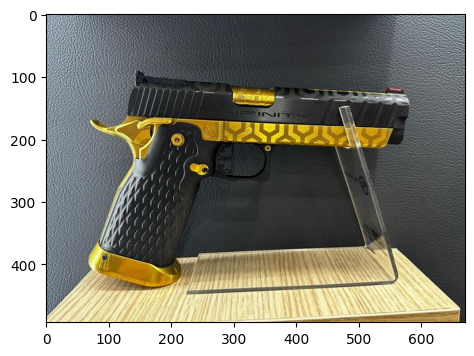

In [54]:
if result_classes[result]=='köpek havlaması':
    import matplotlib.image as mping 
    plt.figure(figsize=(12,4)) 
    img = mping.imread('dog.jpg')
    imgplot=plt.imshow(img) 
    plt.show() 
if result_classes[result]=='klima':
    import matplotlib.image as mping 
    plt.figure(figsize=(12,4)) 
    img = mping.imread('klima.jpg')
    imgplot=plt.imshow(img) 
    plt.show() 
if result_classes[result]=='korna':
    import matplotlib.image as mping 
    plt.figure(figsize=(12,4)) 
    img = mping.imread('korna.jpg')
    imgplot=plt.imshow(img) 
    plt.show() 
if result_classes[result]=='siren':
    import matplotlib.image as mping 
    plt.figure(figsize=(12,4)) 
    img = mping.imread('siren.png')
    imgplot=plt.imshow(img) 
    plt.show() 
if result_classes[result]=='çocuk sesleri':
    import matplotlib.image as mping 
    plt.figure(figsize=(12,4)) 
    img = mping.imread('child.jpg')
    imgplot=plt.imshow(img) 
    plt.show() 
if result_classes[result]=='sondaj':
    import matplotlib.image as mping 
    plt.figure(figsize=(12,4)) 
    img = mping.imread('sondaj.jpg')
    imgplot=plt.imshow(img) 
    plt.show() 
if result_classes[result]=='motor sesi':
    import matplotlib.image as mping 
    plt.figure(figsize=(12,4)) 
    img = mping.imread('motor.jpg')
    imgplot=plt.imshow(img) 
    plt.show() 
if result_classes[result]=='silah sesi':
    import matplotlib.image as mping 
    plt.figure(figsize=(12,4)) 
    img = mping.imread('silah.jpg')
    imgplot=plt.imshow(img) 
    plt.show() 
if result_classes[result]=='darbeli kırıcı':
    import matplotlib.image as mping 
    plt.figure(figsize=(12,4)) 
    img = mping.imread('darbeli.jpg')
    imgplot=plt.imshow(img) 
    plt.show() 
if result_classes[result]=='sokak müziği':
    import matplotlib.image as mping 
    plt.figure(figsize=(12,4)) 
    img = mping.imread('muzik.jpg')
    imgplot=plt.imshow(img) 
    plt.show()
    # nice_work